In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, re
import time
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
from scipy.fftpack import fft, ifft
import pandas as pd

import stfft
import general
import eegFilter
from eegAnalysis import EEGAnalysis

from tqdm import tqdm

fs = 2000

- only grating trials, no entrain trials yet
- only erp signals, no total power spectrum yet

In [2]:
sgchdir = "../../Data/ChenZhou/EEG/SgCh"

marker_bias = pd.read_csv(os.path.join(sgchdir, "marker_bias.csv"))
get_marker_bias = lambda expname: marker_bias[marker_bias.exp==expname].bias.values[0]
namepattern = r"(\d{6})-(\d)-(\d{1,2})_ch(\d{3}).mat"





for chidx in tqdm(range(123)):
# chidx = 98
    chdir = os.path.join(sgchdir, "ch%03d"%(chidx+1))
    files = []
    for item in os.listdir(chdir):
        if re.match(namepattern, item):
            files.append(item)

    ch_erp = {
        "5": np.zeros(7*fs),
        "10": np.zeros(12*fs)
    }


    # ch_total_power = {
    #     "5": np.zeros()
    # }

    for eachfile in files:
        rawdata = rawdata = loadmat(os.path.join(chdir, eachfile))

        date, mode, iti, chname = re.findall(namepattern, eachfile)[0]
        expname="%s-%s-%s"%(date, mode, iti)

        channel = rawdata["values"][0,:]
        try:
            marker = rawdata["markers"]["grating"][0][0][0,:]+get_marker_bias(expname)
        except IndexError:
            continue  #git up this file

        try:
            epoch = general.split_datawithmarker(channel, marker, (-2,int(iti)), fs)
        except ValueError:
            continue # give up this file

        ch_erp[iti] = np.vstack((ch_erp[iti], epoch))

#     savemat(os.path.join(chdir, "ch%03d_erp_entrain.mat"%(chidx)), ch_erp)

        

    frange = np.logspace(np.log10(1), np.log10(200), 40) # 80, 200, 500
    # ERP
    plt.figure(figsize=(10,15))
    plt.subplot(3,1,1)
    ERP = np.mean(ch_erp["5"][1:,:],0)
    SEM = np.std(ch_erp["5"][1:,:],0) / np.sqrt(np.size((ch_erp["5"][1:,:]),0))
    plt.plot(np.linspace(-2,5,7*fs), ERP)
    plt.fill_between(np.linspace(-2,5,7*fs), ERP-SEM, ERP+SEM, alpha=0.5, color="#88c0d0")
    plt.xlim([-2, 5])
    plt.ylabel("IFP (uV)")
    # plt.xlabel("time (s)")
    plt.title("ITI = 5s")

    pxx_erp_5 = stfft.dwt_tf(np.reshape(ERP, (1, len(ERP))), fs, frange, reflection=False, zscore=True)


    plt.subplot(3,1,2)
    ERP = np.mean(ch_erp["10"][1:,:],0)
    SEM = np.std(ch_erp["10"][1:,:],0) / np.sqrt(np.size((ch_erp["10"][1:,:]),0))
    plt.plot(np.linspace(-2,10,12*fs), ERP)
    plt.fill_between(np.linspace(-2,10,12*fs), ERP-SEM, ERP+SEM, alpha=0.5, color="#88c0d0")
    plt.xlim([-2, 5])
    plt.ylabel("IFP (uV)")
    # plt.xlabel("time (s)")
    plt.title("ITI = 10s, enlarged")

    plt.subplot(3,1,3)
    ERP = np.mean(ch_erp["10"][1:,:],0)
    SEM = np.std(ch_erp["10"][1:,:],0) / np.sqrt(np.size((ch_erp["10"][1:,:]),0))
    plt.plot(np.linspace(-2,10,12*fs), ERP)
    plt.fill_between(np.linspace(-2,10,12*fs), ERP-SEM, ERP+SEM, alpha=0.5, color="#88c0d0")
    plt.xlim([-2, 10])
    plt.ylabel("IFP (uV)")
    plt.xlabel("time (s)")
    plt.title("ITI = 10s")
    
#     plt.savefig(os.path.join(sgchdir, 'preview', "ch%03d_erp.png"%(chidx)), bbox_inches='tight')
    plt.close()
    if chidx==3:
        break

FileNotFoundError: File b'../../Data/ChenZhou/EEG/SgCh/marker_bias.csv' does not exist

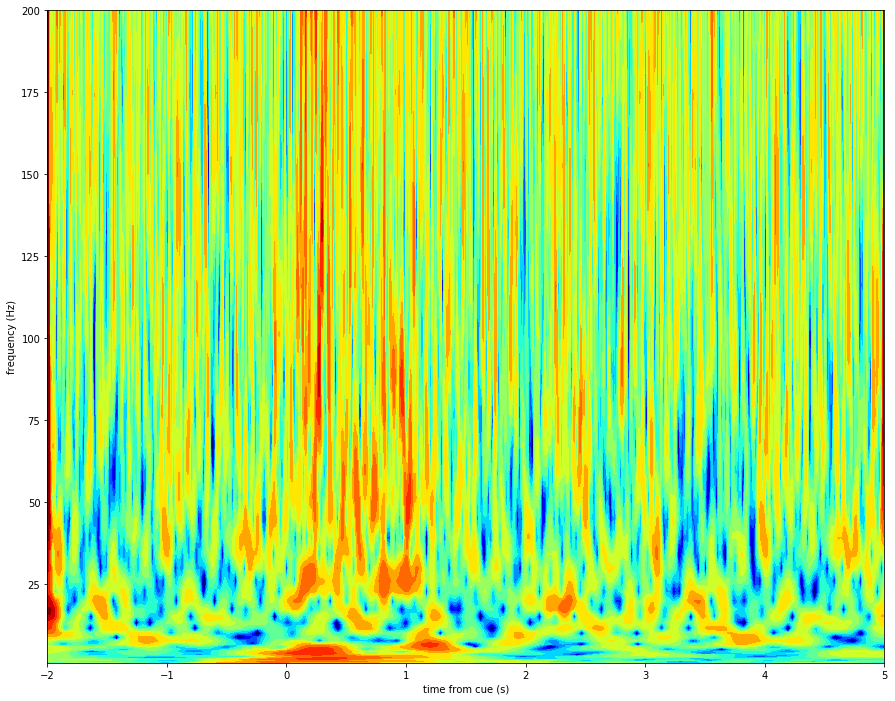

In [12]:
plt.figure(figsize=(15,12))
plt.contourf(np.linspace(-2,5,3500), frange, pxx_erp_5[:,::4], 40, cmap=plt.get_cmap("jet"))
plt.xlabel("time from cue (s)")
plt.ylabel("frequency (Hz)")
plt.clim([-3,3])
plt.show()
# plt.savefig("somatosensory_demo_notap_grating_tf_0_80.eps")